<a href="https://colab.research.google.com/github/jjrodcast/MaskDectector/blob/master/VC_MaskDetector_TL_v03_kfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
path_root = '/gdrive/My Drive/Cursos Personales/DIPLOMADO IA-PUCP/2. Vision Artificial/Trabajo Final - Vision Computacional/dataset/'

### Calculate the media and std of our dataset

In [5]:
train_dataset = torchvision.datasets.ImageFolder(path_root+'train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224), #224x224
                                                    transforms.ToTensor() # Convertir en un rango de 0-1
                                                ]))

print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 2206
    Root location: /gdrive/My Drive/Cursos Personales/DIPLOMADO IA-PUCP/2. Vision Artificial/Trabajo Final - Vision Computacional/dataset/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [6]:
%%time
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=False, num_workers=0)

nimages = 0
mean = 0.0
var = 0.0
for i_batch, batch_target in enumerate(train_loader):
    batch = batch_target[0]
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute MEAN and VAR here
    mean += batch.mean(2).sum(0) 
    var += batch.var(2).sum(0)

mean /= nimages
var /= nimages
std = torch.sqrt(var)

print(mean)
print(std)

tensor([0.5729, 0.4799, 0.4408])
tensor([0.2361, 0.2238, 0.2231])
CPU times: user 8.1 s, sys: 397 ms, total: 8.49 s
Wall time: 10.5 s


tensor([0.5737, 0.4802, 0.4410])

tensor([0.2369, 0.2243, 0.2235])

CPU times: user 7.83 s, sys: 395 ms, total: 8.22 s

Wall time: 10.2 s



### Data augmentation and normalization for training

In [0]:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(160), #transforms.RandomResizedCrop(160),
        transforms.CenterCrop(160), #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5737, 0.4802, 0.4410],[0.2369, 0.2243, 0.2235]) #([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.5737, 0.4802, 0.4410],[0.2369, 0.2243, 0.2235]) #([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = path_root

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
dataset_sizes

{'test': 551, 'train': 2206}

In [9]:
class_names

['mask', 'nomask']

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



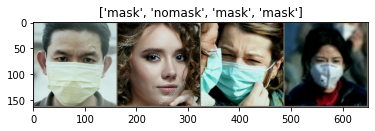

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Epoch: {}'.format(best_epoch))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.5)
#optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

**Train and evaluate**

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [73]:
best_model_conv_ffe = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.3971 Acc: 0.8264
test Loss: 0.1478 Acc: 0.9492

Epoch 1/99
----------
train Loss: 0.3225 Acc: 0.8608
test Loss: 0.1120 Acc: 0.9637

Epoch 2/99
----------
train Loss: 0.3111 Acc: 0.8617
test Loss: 0.1389 Acc: 0.9474

Epoch 3/99
----------
train Loss: 0.2994 Acc: 0.8699
test Loss: 0.0983 Acc: 0.9746

Epoch 4/99
----------
train Loss: 0.3001 Acc: 0.8726
test Loss: 0.0942 Acc: 0.9710

Epoch 5/99
----------
train Loss: 0.2779 Acc: 0.8776
test Loss: 0.1059 Acc: 0.9637

Epoch 6/99
----------
train Loss: 0.2830 Acc: 0.8794
test Loss: 0.0860 Acc: 0.9764

Epoch 7/99
----------
train Loss: 0.2665 Acc: 0.8794
test Loss: 0.0803 Acc: 0.9819

Epoch 8/99
----------
train Loss: 0.2424 Acc: 0.9034
test Loss: 0.1148 Acc: 0.9601

Epoch 9/99
----------
train Loss: 0.2663 Acc: 0.8812
test Loss: 0.0901 Acc: 0.9746

Epoch 10/99
----------
train Loss: 0.2642 Acc: 0.8858
test Loss: 0.0856 Acc: 0.9837

Epoch 11/99
----------
train Loss: 0.2749 Acc: 0.8776
test Loss: 0.0881 Acc: 0.9710

Epoch 12/99


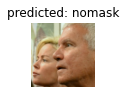

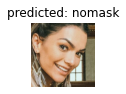

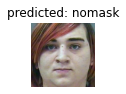

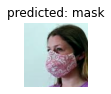

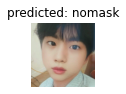

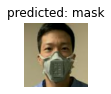

In [74]:
visualize_model(best_model_conv_ffe)

plt.ioff()
plt.show()

In [0]:
# Save Model
PATH_SAVE = '/gdrive/My Drive/Cursos Personales/DIPLOMADO IA-PUCP/2. Vision Artificial/Trabajo Final - Vision Computacional/saved_models/'
torch.save(best_model_conv_ffe, PATH_SAVE+'best_model_conv_ffe2.model')

In [0]:
# Load Model
loaded_conv_ffe = torch.load(PATH_SAVE+'best_model_conv_ffe2.model')

In [0]:
#loaded_conv_ffe.state_dict()

In [0]:
# Iterate over data.
def fx_evaluate_model(model, dataset):
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in dataset:
        with torch.set_grad_enabled(False):
            inputs = inputs.to(device)
            labels = labels.to(device)
       
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    value_loss = running_loss / len(dataset.dataset)
    value_acc = running_corrects.double() / len(dataset.dataset)

    print('Loss: {:4f}'.format(value_loss))
    print('Accuracy: {:4f}'.format(value_acc))

In [79]:
fx_evaluate_model(model=best_model_conv_ffe, dataset=dataloaders['train'])

Loss: 0.089777
Accuracy: 0.977788


In [80]:
fx_evaluate_model(model=best_model_conv_ffe, dataset=dataloaders['test'])

Loss: 0.082834
Accuracy: 0.985481


In [81]:
fx_evaluate_model(model=loaded_conv_ffe, dataset=dataloaders['train'])

Loss: 0.089777
Accuracy: 0.977788


In [82]:
fx_evaluate_model(model=loaded_conv_ffe, dataset=dataloaders['test'])

Loss: 0.082834
Accuracy: 0.985481


Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

**Train and evaluate**



In [84]:
%%time 
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.3330 Acc: 0.8876
test Loss: 0.0324 Acc: 0.9891

Epoch 1/99
----------
train Loss: 0.2526 Acc: 0.9139
test Loss: 0.0164 Acc: 0.9964

Epoch 2/99
----------
train Loss: 0.1797 Acc: 0.9483
test Loss: 0.0191 Acc: 0.9982

Epoch 3/99
----------
train Loss: 0.1124 Acc: 0.9646
test Loss: 0.0102 Acc: 1.0000

Epoch 4/99
----------
train Loss: 0.0386 Acc: 0.9905
test Loss: 0.0058 Acc: 1.0000

Epoch 5/99
----------
train Loss: 0.0250 Acc: 0.9941
test Loss: 0.0133 Acc: 0.9946

Epoch 6/99
----------
train Loss: 0.0182 Acc: 0.9968
test Loss: 0.0101 Acc: 0.9982

Epoch 7/99
----------
train Loss: 0.0097 Acc: 0.9991
test Loss: 0.0071 Acc: 0.9982

Epoch 8/99
----------
train Loss: 0.0085 Acc: 0.9991
test Loss: 0.0101 Acc: 0.9982

Epoch 9/99
----------
train Loss: 0.0079 Acc: 0.9986
test Loss: 0.0084 Acc: 1.0000

Epoch 10/99
----------
train Loss: 0.0105 Acc: 0.9977
test Loss: 0.0105 Acc: 1.0000

Epoch 11/99
----------
train Loss: 0.0083 Acc: 0.9982
test Loss: 0.0079 Acc: 1.0000

Epoch 12/99


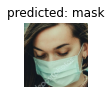

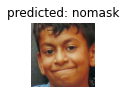

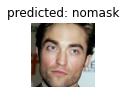

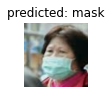

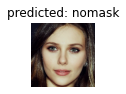

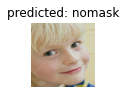

In [85]:
visualize_model(model_ft)

In [0]:
# Save Model
PATH_SAVE = '/gdrive/My Drive/Cursos Personales/DIPLOMADO IA-PUCP/2. Vision Artificial/Trabajo Final - Vision Computacional/saved_models/'
torch.save(model_ft, PATH_SAVE+'best_model_conv_ft2.model')

In [87]:
# Load Model
loaded_conv_ft = torch.load(PATH_SAVE+'best_model_conv_ft2.model')
loaded_conv_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
#loaded_conv_ffe.state_dict()

In [89]:
fx_evaluate_model(model=model_ft, dataset=dataloaders['train'])

Loss: 0.007151
Accuracy: 0.998640


Loss: 0.110021
Accuracy: 0.966908

In [90]:
fx_evaluate_model(model=model_ft, dataset=dataloaders['test'])

Loss: 0.010151
Accuracy: 1.000000


Loss: 0.096071
Accuracy: 0.974592

In [91]:
fx_evaluate_model(model=loaded_conv_ft, dataset=dataloaders['train'])

Loss: 0.007151
Accuracy: 0.998640


In [92]:
fx_evaluate_model(model=loaded_conv_ft, dataset=dataloaders['test'])

Loss: 0.010151
Accuracy: 1.000000
